In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib
from astropy.cosmology import FlatLambdaCDM

from utils_orbs.orb_paths import SetupPaths
import utils_orbs.readsubfHDF5Py3 as readSub
# from utils.read_group_cats import ReadCats
from utils_orbs.merger_trees import TraceMergerTree
from utils_orbs.readMergerHistoryFiles import FindHistory
from utils_orbs.vectorCorrection import vectorCorrection as vector

paths = SetupPaths()

imported h5py...
modules seem to have loaded?


In [2]:
plt.show();
plt.rcParams.update({'font.size':16,"xtick.direction":"in","ytick.direction":"in", 
                     "xtick.top":True, "ytick.right":True,"text.usetex":False,
                     "xtick.labelsize":18,"ytick.labelsize":18})

# Definitions for this notebook:

In [3]:
z_directory = {"33":"z=2","40":"z=1.5","50":"z=1"}

In [4]:
orbit_dict = {}
for snap in [33,40,50]:
    f = h5py.File(f"{paths.path_data}orbitdata_{snap}.hdf5",'r')
    orbit_dict[str(snap)] = {}
    for key, val in f.items():
        orbit_dict[str(snap)][key] = np.array(val)
    f.close()

f = h5py.File(f"{paths.path_data}snapshot_data.hdf5",'r')
snap_dict = {}
for key, val in f.items():
    snap_dict[key] = np.array(val)
f.close()

In [7]:
orbit_dict['33']['']

{'GroupFlag': array([[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]]),
 'MergerFlag': array([1., 1., 1., ..., 1., 1., 1.]),
 'MergerSnapshot': array([39., 42., 48., ..., 34., 39., 35.]),
 'Separations': array([[  0.        ,   0.        ,   0.        , ..., 173.86558823,
         164.90350042,          nan],
        [  0.        ,   0.        ,   0.        , ..., 177.62722796,
         165.45478612,          nan],
        [  0.        ,   0.        ,   0.        , ..., 150.6053166 ,
         140.23880788,          nan],
        ...,
        [  0.        ,   0.        ,   0.        , ...,  30.01359329,
          29.3608971 ,          nan],
        [  0.        ,   0.        ,   0.        , ...

# Remove all <10ckpc/h separations

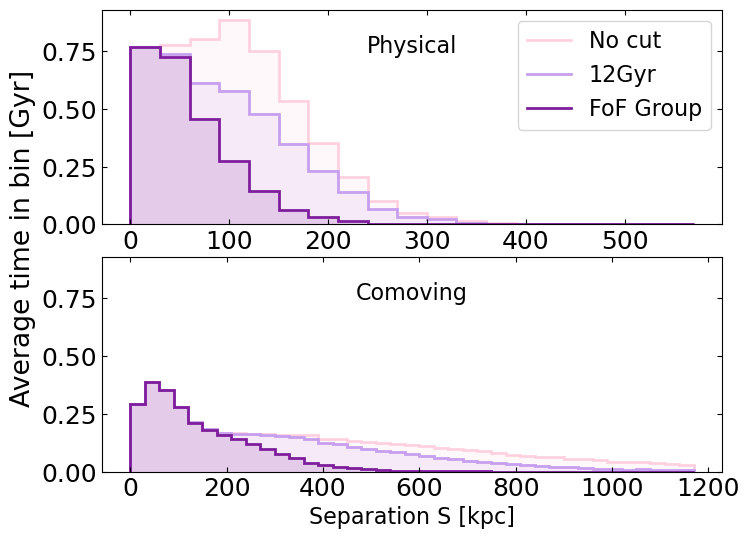

In [5]:
'''
# trying slight modification of the elapsed_time array construction compared to previous plots
# this approximates that a pair stayed at the same separation for the amount of 
# time elapsed since the snapshot before
---
might need to do something else if we are only considering seps > 10kpc? 
'''

fig, ax = plt.subplots(2, 1, figsize=(8,6), sharey=True, sharex=False, 
                       gridspec_kw={'width_ratios': [1], 
                                    'height_ratios':[1,1],
                                    'wspace': 0.10,
                                    "hspace":0.15})

    # get physical separations from snapshot 40
snap = 40
orb = orbit_dict[str(snap)]
sep_matrix_kpc = orb["Separations"]

colors = ["xkcd:light pink","xkcd:lavender","xkcd:purple"]
j = 0    

for i in ["No cut","12Gyr","FoF Group"]:


        # get comoving separations
    scales = snap_dict['Scale'][::-1][:-1] # gives scale in same order as orbit data
    scale_matrix = np.tile(scales,(len(sep_matrix_kpc),1))
    sep_matrix_ckpc = sep_matrix_kpc/scale_matrix

        # get elapsed time (positive)
    elapsed_time = np.diff(snap_dict["Lookback Time"][::-1]) 
    elapsed_matrix = np.tile(elapsed_time,(len(sep_matrix_kpc),1))

        # create mask to filter out nan and zero values from the separation matrix
    nan_sep = np.isnan(sep_matrix_kpc)
    zero_sep = sep_matrix_kpc == 0
    matrix_mask = ~nan_sep&~zero_sep

        # create mask to only select mergers
    merger_array = np.array(orb["MergerFlag"],dtype='bool')
    merge_mask = np.tile(merger_array,(99,1)).transpose()

        # define bins for histograms
    bins_kpc = np.arange(0,600,30)
    bins_ckpc = np.arange(0,1200,30)
    
        # orbit start at LBT of 12Gyr
    start_12gyrmask = (snap_dict["Lookback Time"][::-1][:-1] < 12)    
    start_12gyr = np.tile(start_12gyrmask,(len(sep_matrix_kpc),1))
    
        # orbit start when in same FoF group
    start_FoF = orb['GroupFlag'] == True
    
        # create full matrix mask including:
        # mergers, non-zero separations, and start time
    if i == "12Gyr":
        start_mask = start_12gyr&matrix_mask&merge_mask
        
    elif i =="FoF Group":
        start_mask = start_FoF&matrix_mask&merge_mask
    else:
        start_mask = matrix_mask&merge_mask
        
        #defining 
    xx_kpc = sep_matrix_kpc[start_mask]
    xx_ckpc = sep_matrix_ckpc[start_mask]
    
        # calculate number of mergers and elapsed time - used for weights 
    elapsed = elapsed_matrix[start_mask]
    num_mergers = np.count_nonzero(merger_array)

        # create histograms
    vals_kpc, edges_kpc = np.histogram(xx_kpc,bins=bins_kpc,weights=elapsed/num_mergers)
    vals_ckpc, edges_ckpc = np.histogram(xx_ckpc,bins=bins_ckpc,weights=elapsed/num_mergers)

    ###                      ###
    # physical separation plot #
    ###                      ###
    ax[0].stairs(vals_kpc,edges_kpc,color=colors[j],lw=2,fill=True,alpha=0.15)
    ax[0].stairs(vals_kpc,edges_kpc,color=colors[j],lw=2,label=i)

    ###                      ###
    # comoving separation plot #
    ###                      ###
    ax[1].stairs(vals_ckpc,edges_ckpc,color=colors[j],lw=2,fill=True,alpha=0.15)
    ax[1].stairs(vals_ckpc,edges_ckpc,color=colors[j],lw=2,label=i)

    j += 1

for i,label in enumerate(["Physical","Comoving"]):
    x0,x1 = ax[i].get_xlim()
    y0,y1 = ax[i].get_ylim()
    locx = 0.5*(x1-x0) + x0
    locy = 0.80*(y1-y0) + y0
    ax[i].text(locx,locy,label,ha="center")
    
ax[0].legend()
ax[1].set_xlabel("Separation S [kpc]")
fig.supylabel("Average time in bin [Gyr]",x=0.01)
plt.show()
